# Derived Benthic Habitat of California's Nearshore Marine Protected Areas (MPAs)
MS 263 Final Project

Caroline Daley | Moss Landing Marine Laboratories 

May 2025

Please install [xDEM](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) to run the below code ([xDEM contributors 2024](https://doi.org/10.5281/zenodo.11492983)). 

In [3]:
import matplotlib.pyplot as plt
import xdem
import geopandas as gpd
import os
import rioxarray
import numpy as np
import xarray as xr
from rasterstats import zonal_stats

ModuleNotFoundError: No module named 'xdem'

In [1]:
%rasterstats zonal_stats

UsageError: Line magic function `%rasterstats` not found.


### Visualize & Explore Your Data

I import one of the digital elevation models (DEMs) to visualize some of the habitat metrics that I am going to explore in this project. Running this code also allows me to check that the xDEM package is running smoothly and that the outputs are what I might expect! The below code is adopted from the ['Terrain Attributes'](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) tutorial on the xDEM website. 

In [2]:
pigeon_point_file = '/Users/carolinedaley/Documents/MLML/MS263/Project/Data/DEM/Bathymetry_OffshorePigeonPoint.tif'
pigeon_point_DEM = xdem.DEM(pigeon_point_file)

NameError: name 'xdem' is not defined

In [ ]:
attributes = xdem.terrain.get_terrain_attribute(
    pigeon_point_DEM.data,
    resolution=pigeon_point_DEM.res,
    attribute=["slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity", "fractal_roughness"],
)

plt.figure(figsize=(8, 6.5))

plt_extent = [pigeon_point_DEM.bounds.left, pigeon_point_DEM.bounds.right, pigeon_point_DEM.bounds.bottom, pigeon_point_DEM.bounds.top]

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
labels = ["Hillshade", "Slope (Â°)", "Aspect (Â°)", "Curvature (100 / m)", "Terrain Ruggedness Index", "Rugosity"]
vlims = [(None, None) for i in range(6)]
vlims[3] = [-2, 2]

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.imshow(attributes[i].squeeze(), cmap=cmaps[i], extent=plt_extent, vmin=vlims[i][0], vmax=vlims[i][1])
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## Prepare for Analysis

### Import DEMs and Shapfiles

Import CCFRP gridcells from local folder. These can also be found on the [California Open Data Portal](https://data.ca.gov/dataset/california-collaborative-fisheries-research-program). 

***CHECK THIS***

In [64]:
grid_cells_shp = '/Users/carolinedaley/Documents/MLML/MS263/Project/Data/shapfiles/CCFRP_Grid_Cells_2021.shp'
grid_cells = gpd.read_file(grid_cells_shp)

Make a list of the DEMs I will be working with. 

In [26]:
dem_folder = '/Users/carolinedaley/Documents/MLML/MS263/Project/Data/DEM'
dem_list = []

for file_name in os.listdir(data_folder):
    if file_name[-4:] == '.tif':
        dem_list.append(file_name)

dem_list.sort()

print(dem_list)

['Bathymetry_OffshorePigeonPoint.tif']


### Define Output Directory 

In [ ]:
output_dir = '/Users/carolinedaley/Documents/MLML/MS263/Project/Data/derived_habitat_attributes'
os.makedirs(output_dir, exist_ok=True)

## Calculate Habitat Attributes Using xDEM

Define which habitat attributes I would like to calculate. 

In [61]:
habitat_attributes = [
    "slope", "aspect"
]

Calculate my specified habitat attributes for each of my DEMs of interest. The derived habitat attribtues will be exported into the above identified directory.

In [59]:
for dem_name in dem_list:
    dem_path = os.path.join(dem_folder, dem_name)
    print(f"Calculating habitat attributes for: {dem_name}")

    dem = xdem.DEM(dem_path)

    for attribute in habitat_attributes:
        data_np = xdem.terrain.get_terrain_attribute(
            dem.data,  
            resolution=dem.res,
            attribute=attribute
        )

        # Ensure data_np has the same dtype as the original DEM data
        data_np = data_np.astype(dem.data.dtype) 

        # Create a new DEM object to hold the computed attribute
        ddem = dem.copy() 

        # Update the data of the copy with the computed terrain attribute
        ddem.data = data_np 

        # Save the computed attribute directly to a file
        out_path = os.path.join(output_dir, f"{os.path.splitext(dem_name)[0]}_{attribute}.tif")
        ddem.save(out_path)

print("Calculation complete.")

Calculating habitat attributes for: Bathymetry_OffshorePigeonPoint.tif
ðŸŽ‰ Habitat attribute rasters successfully generated!


### Sanity Check
Check out the slope product that you generated! 


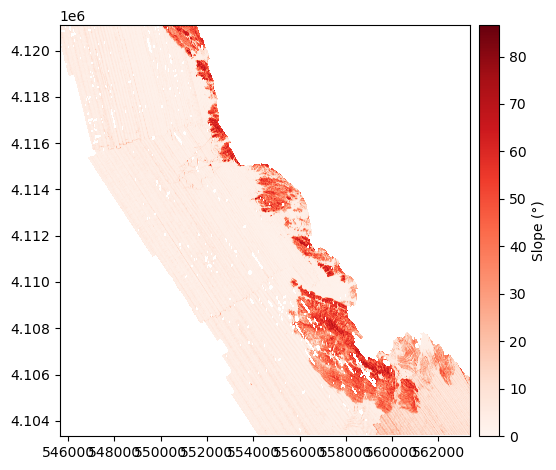

In [60]:
test_file = '/Users/carolinedaley/Documents/MLML/MS263/Project/Data/derived_habitat_attributes/Bathymetry_OffshorePigeonPoint_slope.tif'
test = xdem.DEM(test_file)

slope = test.slope()
slope.plot(cmap="Reds", cbar_title="Slope (Â°)")

# TO DO's

**1. Import CCFRP grid cell shapefile**
- Figure out how to retain MPA/REF + gridcell ID information to collate with CCFRP data (CA Open Data?)

**2. Figure out how to extract summarized habitat attributes**
- Loop through each DEM? Join DEM's together and cookie cutter once? 
- Calculate average habitat attributes within each gridcell + MPA/REF site
- Standard deviation, variance, standard error, max, min...? 

**3. Perform a PCA**

In [1]:
# Prepare a list to store results
results = []

# Loop through each DEM
for dem_path in glob.glob(os.path.join(dem_folder, "*.tif")):
    metrics = calculate_habitat_metrics(dem_path)
    dem_name = os.path.basename(dem_path)

    for metric_name, metric_array in metrics.items():
        # Save each metric as temporary raster for zonal_stats
        with rasterio.open(dem_path) as src:
            profile = src.profile
            profile.update(dtype='float32', count=1)
            
            temp_path = f"temp_{metric_name}.tif"
            with rasterio.open(temp_path, 'w', **profile) as dst:
                dst.write(metric_array.astype('float32'), 1)

        # Calculate zonal stats
        stats = zonal_stats(shapefile_path, temp_path, stats=['mean'], nodata=profile['nodata'])
        
        # Append each metric to the result list with AOI index
        for i, stat in enumerate(stats):
            if len(results) <= i:
                results.append({"AOI_ID": aoi_gdf.iloc[i].get("id", i)})
            results[i][f"{dem_name}_{metric_name}_mean"] = stat['mean']

        os.remove(temp_path)  # Clean up


NameError: name 'glob' is not defined

### Citations

xDEM contributors. (2024). xDEM (v0.1.0). Zenodo. https://doi.org/10.5281/zenodo.11492983